In [1]:
%load_ext autoreload
%autoreload 2

from joblib import Parallel, delayed
import multiprocessing

from tqdm import tqdm, tqdm_notebook
from IPython.display import display
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import json
import pickle
import os
import sys
sys.path.append('../..')
from helper.orderbook_trader import OrderbookTradingSimulator
from helper.manage_orderbooks import *
from helper.evaluation import evaluate, plot_evaluation_costs
from helper.general_helpers import add_features_to_orderbooks, load_and_preprocess_historyfiles, discretize_hist_feature

from agents.RL_Agent_Base import RLAgent_Base
from agents.BatchTree_Agent import RLAgent_BatchTree
from agents.QTable_Agent import QTable_Agent

### Load data

In [4]:
data_nov = pickle.load( open( '../../cached_windows_60mins/obs_2016-11_USDT_BTC_maxVol100.p', "rb" ) )
print(len(data_nov))
print(data_nov[0][0])
data_nov[0][0]

541
OrderbookContainer from 2016-11-08T10:00 (factor: 1.0)
  107 bids (best: 705.0)
  110 asks (best: 705.450997)
price: 705.2254744655137
  kind: 'orderbook'


OrderbookContainer from 2016-11-08T10:00 (factor: 1.0)
  107 bids (best: 705.0)
  110 asks (best: 705.450997)
price: 705.2254744655137
  kind: 'orderbook'

In [ ]:
data_dec = pickle.load( open( '../../cached_windows_60mins/obs_2016-12_USDT_BTC_maxVol100.p', "rb" ) )
print(len(data_dec))
print(data_dec[0][0])
data_dec[0][0]

In [ ]:
data_mar = pickle.load( open( '../cached_windows_60mins_V200/obs_2017-03_USDT_BTC_maxVol200.p', "rb" ) )
print(len(data_mar))
print(data_mar[0][0])

### Evaluate

In [14]:
agent_collection = {'VolTime': RLAgent_Base.load(agent_name='QTable_1611-1704_T4_I8_VolTime', path='../trainedAgents/longterm_1611_1704/', ignore_samples=True)}

Start parallel evalutions of 17 strategies over 24 tradingperiods. (num_cores=24)


[Parallel(n_jobs=24)]: Done   2 out of  24 | elapsed:  1.1min remaining: 12.6min
[Parallel(n_jobs=24)]: Done   7 out of  24 | elapsed:  1.3min remaining:  3.0min
[Parallel(n_jobs=24)]: Done  12 out of  24 | elapsed:  1.4min remaining:  1.4min
[Parallel(n_jobs=24)]: Done  17 out of  24 | elapsed:  1.5min remaining:   37.4s
[Parallel(n_jobs=24)]: Done  22 out of  24 | elapsed:  1.7min remaining:    9.2s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:  1.8min finished


done


,VolTime,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,MarketOrder
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,254.548793,723.491572,715.693091,694.063728,666.676756,591.285145,481.199908,343.528788,285.155575,244.842430,239.348656,237.368271,254.430829,284.365451,311.152655,338.276571,616.402103
std,266.006142,426.774790,433.551988,440.303913,447.052485,476.182691,501.609441,448.473116,384.517624,336.408012,284.203615,230.846263,203.154074,171.124526,155.850873,82.838865,102.776842
min,-24.588896,-242.131830,-323.264484,-314.099013,-237.350783,-167.517105,-114.633213,-16.426607,-2.826947,8.394920,24.676496,94.524332,108.782728,140.271163,153.775419,163.166543,437.470574
25%,86.782023,580.023348,580.023348,580.023348,579.132187,387.332801,52.654548,63.586772,84.882392,106.979827,118.267090,138.271384,163.023507,221.450191,247.501991,285.234448,559.434093
50%,170.313931,667.102892,667.102892,667.081131,642.037669,622.473552,408.510925,110.657475,130.245627,141.611238,185.252361,194.550876,221.533861,254.223808,286.873275,330.097750,612.490052
75%,296.129223,774.495614,774.495614,772.344397,731.254562,721.555984,717.665354,537.445070,366.541030,214.275733,247.862340,223.747029,263.957144,292.722036,340.879018,397.744302,656.167134
max,961.936000,1953.394991,1953.394991,1953.394991,1953.394991,1953.394991,1953.394991,1953.303688,1816.322370,1696.797574,1499.715791,1268.307361,1156.598823,1035.487043,960.536661,514.868693,910.253532


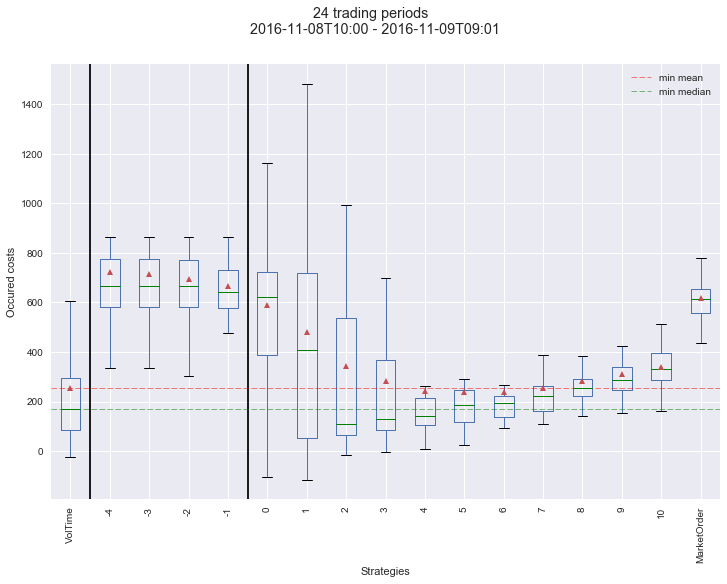

In [17]:
data = data_nov[:24]
baseline='VolTime'
# baseline = list(agent_collection.keys())[0]
costs, slippage = evaluate(
    testdata=data,
    agents=agent_collection,
    baseline=baseline,
    evaluate_actions=[-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10, 'MarketOrder'],
    verbose=False
)

# display(costs.describe())
# plot_evaluation_costs(costs, hline=baseline)
display(slippage.describe())
plot_evaluation_costs(slippage, hline=baseline, showfliers=False)

'6'

VolTime        254.548793
-4             723.491572
-3             715.693091
-2             694.063728
-1             666.676756
0              591.285145
1              481.199908
2              343.528788
3              285.155575
4              244.842430
5              239.348656
6              237.368271
7              254.430829
8              284.365451
9              311.152655
10             338.276571
MarketOrder    616.402103
dtype: float64

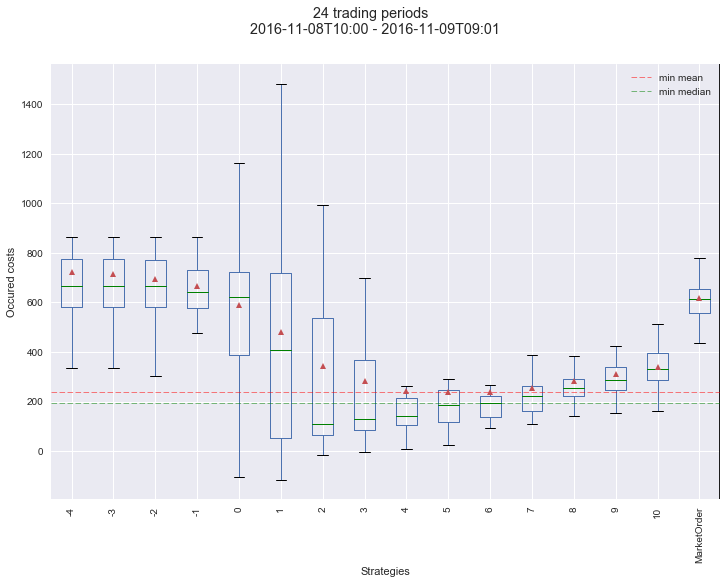

In [28]:
mean = slippage.mean()
display(mean)
plot_evaluation_costs(slippage.iloc[:,1:], hline=mean.argmin(), showfliers=False, vlines=) #, ylim=(100,300))

In [ ]:
data = data_nov[:]
costs = None
baseline = 'QTable_1612-1702_T4_I8_VolTime'
# baseline = list(agent_collection.keys())[0]
costs, slippage = evaluate(
    testdata=data,
    agents=agent_collection,
    baseline=baseline,
    evaluate_actions=[5],
    costs=costs,
    verbose=False
)

# display(costs.describe())
# plot_evaluation_costs(costs, hline=baseline)
display(slippage.describe())
plot_evaluation_costs(slippage, hline=baseline, showfliers=False)

In [ ]:
data = data_dec[:96]
costs = None
baseline = 'QTable_1612-1702_T4_I8'
costs, slippage = evaluate(
    testdata=data,
    agents=agent_collection,
    baseline=baseline,
    evaluate_actions=[5],
    costs=costs,
    verbose=False
)

# display(costs.describe())
# plot_evaluation_costs(costs, hline=baseline)
display(slippage.describe())
plot_evaluation_costs(slippage, hline=baseline)

In [ ]:
slippage

In [ ]:
plot_episode(data_dec[62], limits=[765.527563, 767.819562, 769.347561, 770.875560], consume='volume', volume=100)
#plot_episode(data_dec[62], limits=[765.527563, 767.819562, 769.347561, 770.875560], consume='cash', volume=70000)

In [ ]:
start = 0
end = 100

print(slippage.shape)
slippage.iloc[start:end,:].plot(figsize=(12,8))
plt.plot(slippage.iloc[start:end,:].mean(axis=1).values, color='black', linestyle='--')

tmp = slippage.subtract(slippage.mean(axis=1).values, axis=0)
tmp.iloc[start:end,:].plot(figsize=(12,8))
plt.plot(tmp.iloc[start:end,:].mean(axis=1).values, color='black', linestyle='--')

In [ ]:
name = '1611-1701_USDTBTC_Qtable_100vol10_60T4'

modelpath = os.path.join("../Runs/evaluation/models/{}.json".format(name))
ql = QLearn.load(infile=modelpath)
ql.plot_Q(z_represents="action")
ql.plot_Q(z_represents="Q")
ql.heatmap_Q()

In [ ]:
ql = QLearn.load(infile=modelpath)

T = ql.T
V = ql.V
period_length = ql.period_length
actions = ql.actions

filename_train = '/home/axel/data/obs_2016-12_USDT_BTC_range1.2.dict'
filename_test = '/home/axel/data/obs_2017-02_USDT_BTC_range1.2.dict'

episodes_train = OrderbookEpisodesGenerator(filename=filename_train, episode_length=T*period_length)
print("Length of episodes_train: {}".format(len(episodes_train)))

episodes_test = OrderbookEpisodesGenerator(filename=filename_test, episode_length=T*period_length)
print("Length of episodes_test: {}".format(len(episodes_test)))

In [ ]:
def plot_experiment_results(experiments, name=None, ylim=None, showfliers=False, hline=None):
    assert isinstance(hline, str) or hline is None
    
    experiments.plot.box(showmeans=True, color={'medians':'green'}, figsize=(12, 8), showfliers=showfliers)

    plt.axvline(2.5, color='black')
    plt.axvline(3.5, color='black')
    plt.axhline(0, color='black')
    
    if hline is not None:
        plt.axhline(experiments[hline].mean(), color='red', alpha=0.5, linewidth=2, linestyle='--', label='min mean')
        plt.axhline(experiments[hline].median(), color='green', alpha=0.5, linewidth=2, linestyle='--', label='min median')
    
    title = "{} samples  \n{} - {}".format(len(experiments), experiments.index[0], experiments.index[-1])
    if name is not None:
        title = "{}: {}".format(name, title)
    print(title)
    #plt.suptitle(title)
    plt.xlabel("Strategies")
    plt.ylabel("Occured costs")
    plt.savefig("boxplot_train.pdf")
    plt.xticks(rotation=70)
    if ylim is not None:
        plt.ylim(ylim)    
    plt.legend(loc='best')
    
    plt.show()

In [ ]:
def run_Q(V, H, T, ql, episode_windows, actions, costs=None):
    costs = pd.DataFrame([])
    period_length = int(H/T)

    for e, episode in tqdm(enumerate(episode_windows)):
        index = episode[0].timestamp
        
        volume = V
        
        ## Learned strategy
        ots = OrderbookTradingSimulator(orderbooks=episode, volume=volume, tradingperiods=T,
                                         period_length=period_length)
        for tt in range(1, T+1, 1)[::-1]:
            new_vol = round_custombase(ots.volume, base=ql.vol_intervals)  
        
            if new_vol > 0:
                idx = (T-tt)*period_length
                state = ql.state_as_string(time_left=tt, volume_left=new_vol/V)
                # print(idx, state)
                action = ql.chooseAction(state)
        
                # print(state, action)
                obs = episode[period_length * (T-tt)].copy()
                # obs = [elem.copy() for elem in obs_]
            
                ask = obs.get_ask()
                # center = ots.masterbook.get_center()
                limit = ask * (1. + (action/100.))
            else:
                # theoreticall done
                limit == None
            ots.trade(limit = limit, extrainfo={'ACTION':action})
        costs.loc[index, 'Learned_1611-1701'] = ots.history.cost.sum()

    
        ## market order
        ots = OrderbookTradingSimulator(orderbooks=episode, volume=volume, tradingperiods=T,
                                        period_length=period_length)
        ots.trade(limit = None)
        costs.loc[index, 'Market'] = ots.history.cost.sum()
        
        # for a in actions:
        a = 0.4
        lim = episode[0].get_ask() * (1. + (a/100.))
        # print("\n### Fixed limit at: {} (ASK+4) ###".format(lim))
        ots = OrderbookTradingSimulator(orderbooks=episode, volume=volume, tradingperiods=1,
                                        period_length=period_length*T)
        ots.trade(limit = lim)
        key = 'ask*{:1.3f}'.format((1. + (a/100.)))
        costs.loc[index, key] = ots.history.cost.sum()

        
        if e%5==0 or e==len(episode_windows)-1:
            display.clear_output(wait=True)
            plot_experiment_results(costs, name='Testset (USDT-BTC, Feb 2017):')
            
            # costs.to_csv("../Runs/evaluation/Evaluation_obs_TESTSET_2016-12_USDT_BTC_LEARNED_.csv")
            mean = costs.mean()
            print(mean)
            print("Minimal costs reached by S&L strategy: '{}': {:1.4f}".format(mean.argmin(), mean.min()))
        
    return costs

## Check for best S&L Strategy over training data (Nov16-Jan17)

In [ ]:
costs_list_train = pd.concat([
    pd.read_csv("../Runs/evaluation/Evaluation_obs_TRAINSET_2016-11_USDT_BTC.csv", index_col=0),
    pd.read_csv("../Runs/evaluation/Evaluation_obs_TRAINSET_2016-12_USDT_BTC.csv", index_col=0),
    pd.read_csv("../Runs/evaluation/Evaluation_obs_TRAINSET_2017-01_USDT_BTC.csv", index_col=0)])

plot_experiment_results(costs_list_train, name='Trainset (USDT-BTC)', ylim=(-1.5, 1.5))

mean = costs_list_train.mean()
print("Minimal costs reached by S&L strategy: '{}': {:1.4f}".format(mean.argmin(), mean.min()))

### Compare strategies on Testset (Feb2017)

In [ ]:
T = ql.T
V = ql.V
period_length = ql.period_length
print("V={}, T={}, period_length={}".format(V, T, period_length))

costs_list = run_Q(V=100, H=T*period_length, T=T, ql=ql,
                   episode_windows=episodes_test[:5], actions=actions)

In [ ]:
plot_experiment_results(costs_list, name='Trainset (USDT-BTC)')  #, ylim=(-1.5, 1.5))
mean = costs_list_train.mean()
print("Minimal costs reached by S&L strategy: '{}': {:1.4f}".format(mean.argmin(), mean.min()))